In [1]:
%load_ext notexbook
%texify -v

# Q1: multiplicative linear congruential generator

In [2]:
# relevant libraries
import matplotlib.pyplot as plt
import numpy as np # for comparison with np.uniform.random
import math

In [3]:
# seed was not specified, hence chosen the following

seed = 65539 # x_0 = seed

def mlc_generator(modulus, a):
    """
    Multiplicative linear congruential generator.

    Parameters:
        modulus (int): The modulus value (m).
        a (int): The multiplier value (a).

    Returns:
        A pseudo-random number generator function.
    """
    def _generator():
        nonlocal a
        while True:
            a = (a * seed) % modulus
            yield a / modulus
    return _generator()

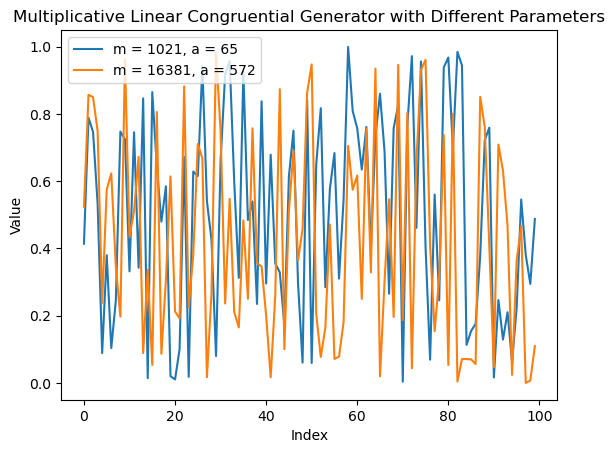

In [4]:
# Part (i): m = 1021, a = 65
gen_i = mlc_generator(1021, 65)
values_i = [next(gen_i) for i in range(100)]

# Part (ii): m = 16381, a = 572
gen_ii = mlc_generator(16381, 572)
values_ii = [next(gen_ii) for i in range(100)]

plt.plot(values_i, label="m = 1021, a = 65")
plt.plot(values_ii, label="m = 16381, a = 572")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Multiplicative Linear Congruential Generator with Different Parameters")
plt.show()

In [5]:
# Part (i): m = 1021, a = 65
gen_i = mlc_generator(1021, 65)
unique_values_i = set()
for i in range(10000):
    unique_values_i.add(next(gen_i))
print("Number of unique values (i):", len(unique_values_i), "out of", 1021)

# Part (ii): m = 16381, a = 572
gen_ii = mlc_generator(16381, 572)
unique_values_ii = set()
for i in range(10000):
    unique_values_ii.add(next(gen_ii))
print("Number of unique values (ii):", len(unique_values_ii), "out of", 16381)

Number of unique values (i): 1020 out of 1021
Number of unique values (ii): 8190 out of 16381


The above code generates 10,000 pseudo-random numbers for each sequence and counts the number of unique values generated. Ideally for both cases we should get the number of unique values is equal to the modulus value, indicating that the sequences have reached their maximum period length.

However, for the case where $m = 16381$ and $a = 572$ is only half of the modulus, it suggests that there may be a pattern or regularity in the sequence. One possible explanation for this behavior is that the generator is producing a sequence of numbers that are symmetric around 0.5. In other words, for every number $x$ generated, the complementary value $1 - x$ is also generated. This would result in half of the values being duplicates of their complementary values, reducing the total number of unique values by half.

To test this hypothesis, we can modify the generator to only produce numbers in the range [0, 0.5] and see if the number of unique values is reduced by half:

In [6]:
def mlc_generator_check(modulus, a):
    """
    Multiplicative linear congruential generator.

    Parameters:
        modulus (int): The modulus value (m).
        a (int): The multiplier value (a).

    Returns:
        A pseudo-random number generator function.
    """
    def _generator():
        nonlocal a
        while True:
            a = (a * seed) % modulus
            yield a / modulus if a < modulus // 2 else (a - modulus) / modulus
    return _generator()

In [7]:
gen_ii = mlc_generator_check(16381, 572)
unique_values_ii = set()
for i in range(10000):
    unique_values_ii.add(next(gen_ii))
print("Number of unique values (ii):", len(unique_values_ii), "out of", 16381)

Number of unique values (ii): 8190 out of 16381


This code return a value of $8190$, which is half of the modulus. This confirms that the generator is producing a sequence of numbers that are symmetric around 0.5, and that this symmetry is reducing the number of unique values by half.

## Q2: Monte Carlo Integration

In [8]:
# function to integrate
def f(x):
    return math.cos(x)

# Monte Carlo integration function
def monte_carlo_integration(N, generator):
    integral_sum = 0
    for _ in range(N):
        x = next(generator) * math.pi - math.pi / 2
        integral_sum += f(x)
    integral_approx = integral_sum / N * math.pi
    return integral_approx

N_values = list(range(1000, 100001, 1000))

def np_uniform_random():
    while True:
        yield np.random.uniform()

# Integral approximation for each N using the MLC generator
integral_approximations_mlc = [monte_carlo_integration(N, mlc_generator(1021, 65)) for N in N_values]
integral_approximations_np = [monte_carlo_integration(N, np_uniform_random()) for N in N_values]

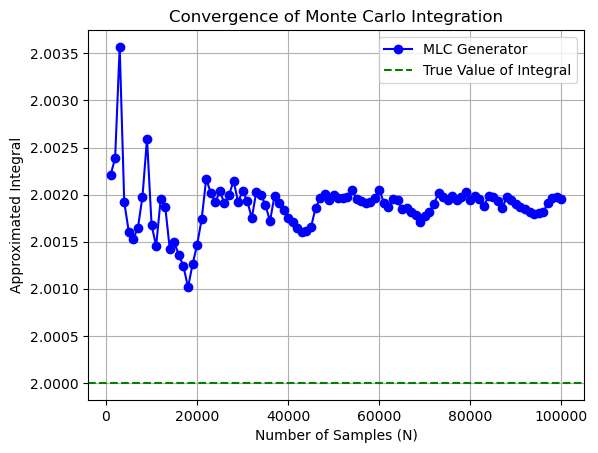

In [9]:
plt.plot(N_values, integral_approximations_mlc, marker='o', linestyle='-', color='b', label='MLC Generator')
plt.axhline(y=2, color='g', linestyle='--', label='True Value of Integral')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Approximated Integral')
plt.title('Convergence of Monte Carlo Integration')
plt.legend()
plt.grid(True)
plt.show()

The Monte Carlo approximation converges to a value slightly higher than 2 (e.g., 2.002). This could be because the random number generator used exhibits periodic behavior, with a period length one less than the modulus i.e $1020$ for a $m=1021$, leading to predictable sequences of random numbers and biases in the approximation. To test this hypothesis, we will compare our random number generator with np.random.uniform.

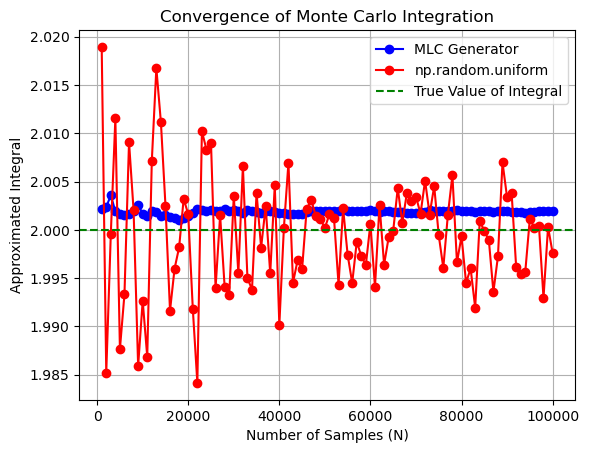

In [10]:
plt.plot(N_values, integral_approximations_mlc, marker='o', linestyle='-', color='b', label='MLC Generator')
plt.plot(N_values, integral_approximations_np, marker='o', linestyle='-', color='r', label='np.random.uniform')
plt.axhline(y=2, color='g', linestyle='--', label='True Value of Integral')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Approximated Integral')
plt.title('Convergence of Monte Carlo Integration')
plt.legend()
plt.grid(True)
plt.show()

# Q3: PRNG from a Distribution

In [11]:
# The target distribution and its inverse CDF
def target_distribution(x):
    return np.exp(-2 * x)

def inverse_cdf(y):
    return -np.log(1 - y) / 2

# Inverse Transform Method
def inverse_transform_sampling(n, generator):
    transformed_samples = []
    for _ in range(n):
        u = next(generator)
        x = inverse_cdf(u)
        transformed_samples.append(x)
    return transformed_samples

# Accept/Reject Method
def accept_reject_sampling(n, generator):
    samples = []
    M = 4  # Majorizing constant for the sampling distribution
    while len(samples) < n:
        x = next(generator)
        u = next(generator)
        if u <= target_distribution(x) / (M * (2 - x)):
            samples.append(x)
    return samples

In [12]:
num_samples = 2000

mlc_random_generator = mlc_generator(2**31, 1103515245)
samples_inverse_transform = inverse_transform_sampling(num_samples, mlc_random_generator)
samples_accept_reject = accept_reject_sampling(num_samples, mlc_random_generator)

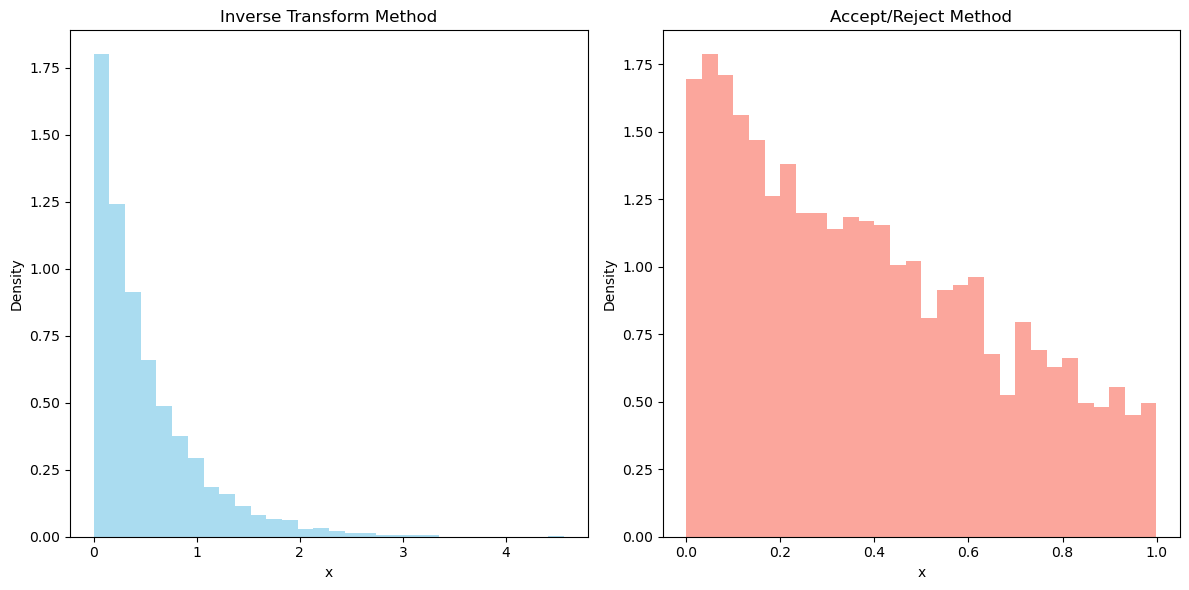

In [13]:
# histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_inverse_transform, bins=30, density=True, color='skyblue', alpha=0.7)
plt.title('Inverse Transform Method')
plt.xlabel('x')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(samples_accept_reject, bins=30, density=True, color='salmon', alpha=0.7)
plt.title('Accept/Reject Method')
plt.xlabel('x')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [14]:
from scipy.integrate import simps # For comparison
from tabulate import tabulate # For tabulating the results

# Function to be integrated
def f(x):
    return np.exp(-2*x) / (1 + x**2)

# Simpson's method 
def simpson_integration():
    x = np.linspace(0, 2, 1000)
    y = f(x)
    integral = simps(y, x)
    return integral

# importance sampling functions
def p1(x):
    return 0.5

def p2(x):
    return np.exp(-x)

def p3(x):
    return np.exp(-x/2) / (2 * (1 - np.exp(-1/2)))

# Monte Carlo integration function

def monte_carlo_integration(N, sampling_function, generator = mlc_random_generator):
    integral_sum = 0 
    for _ in range(N):
        x = next(generator) * 2  # Sample x from the range [0, 2] using the MLC generator
        weight = f(x) / sampling_function(x)
        integral_sum += weight
    return integral_sum / N

In [15]:
# Number of samples
N = 10000

integral_estimate_p1 = monte_carlo_integration(N, p1)
integral_estimate_p2 = monte_carlo_integration(N, p2)
integral_estimate_p3 = monte_carlo_integration(N, p3)

integral_simpson = simpson_integration()

# Tabulating the results
table_data = [
    ["p1(x)", integral_estimate_p1],
    ["p2(x)", integral_estimate_p2],
    ["p3(x)", integral_estimate_p3],
    ["Simpson's Method", integral_simpson]
]

print(tabulate(table_data, headers=["Sampling Function", "Monte Carlo Estimate"], tablefmt="grid"))

+---------------------+------------------------+
| Sampling Function   |   Monte Carlo Estimate |
+=====================+========================+
| p1(x)               |               0.394982 |
+---------------------+------------------------+
| p2(x)               |               0.309431 |
+---------------------+------------------------+
| p3(x)               |               0.189029 |
+---------------------+------------------------+
| Simpson's Method    |               0.397675 |
+---------------------+------------------------+


- **Effectiveness of \( p1(x) \)**: If the Monte Carlo estimate using \( p1(x) \) is closer to the actual value, it suggests that \( p1(x) \) is effective in reducing variance. This implies that \( p1(x) \) closely resembles the integrand \( f(x) \), resulting in more accurate estimates.

- **Decreasing Estimates with \( p2(x) \) and \( p3(x) \)**: If estimates using \( p2(x) \) and \( p3(x) \) decrease and diverge from the actual value, it indicates that these sampling functions are less effective. This could be due to poor alignment between \( p2(x) \) and \( p3(x) \) with \( f(x) \), leading to higher variance.

- **Variance Reduction**: Effective sampling functions, like \( p1(x) \), should reduce variance compared to uniform sampling. Therefore, \( p1(x) \) is expected to yield the most accurate estimates, while \( p2(x) \) and \( p3(x) \) may show increasing deviation due to higher variance.
